In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-10-21 21:07:48.404658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### CSV 파일 불러오기

In [146]:
df = pd.read_csv("datas/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 1. 당뇨병 데이터를 가지고 머신러닝 5가지 분류를 수행.

### 데이터 전처리

In [147]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Text(0.5, 1.0, 'Label')

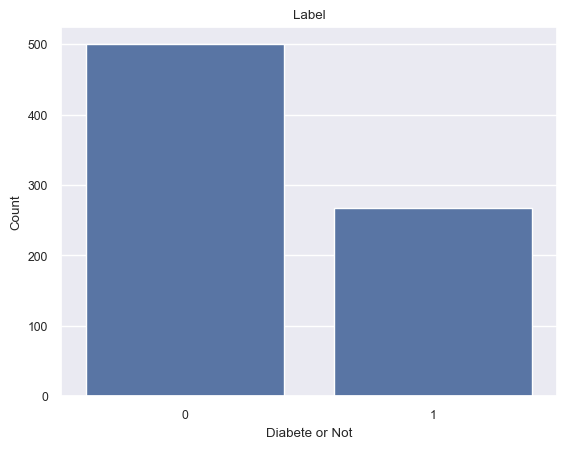

In [148]:
sns.countplot(data = df, x="Outcome")
plt.xlabel("Diabete or Not")
plt.ylabel("Count")
plt.title("Label")

In [149]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [150]:
df_majority = df[df['Outcome'] == 0]
df_minority = df[df['Outcome'] == 1]

df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

df = pd.concat([df_majority_downsampled, df_minority])
df['Outcome'].value_counts()

Outcome
0    268
1    268
Name: count, dtype: int64

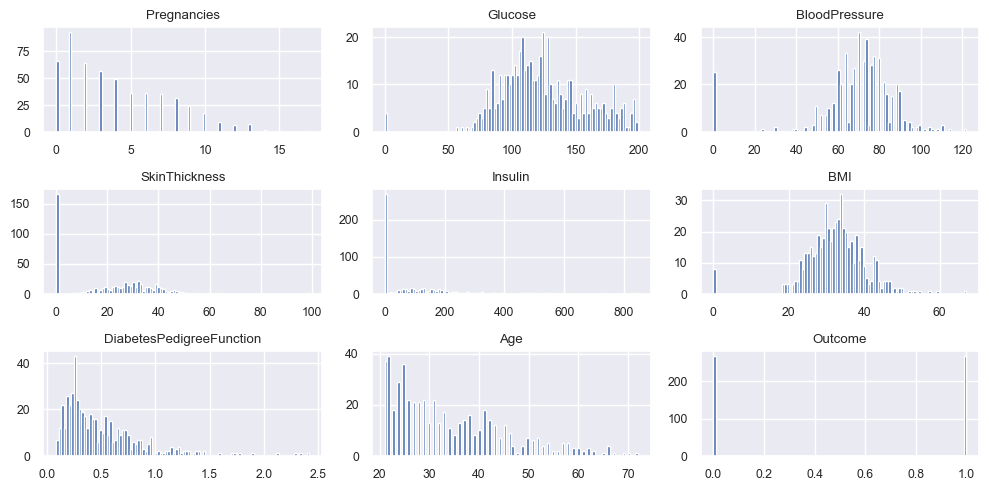

In [151]:
df.hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [152]:
correlation_matrix = df.corr()
print(correlation_matrix)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.115253       0.114106      -0.093456   
Glucose                      0.115253  1.000000       0.128715       0.053073   
BloodPressure                0.114106  0.128715       1.000000       0.190621   
SkinThickness               -0.093456  0.053073       0.190621       1.000000   
Insulin                     -0.033224  0.325281       0.086800       0.448939   
BMI                          0.005954  0.197743       0.244144       0.366816   
DiabetesPedigreeFunction    -0.057325  0.125992       0.040177       0.208554   
Age                          0.512950  0.292035       0.238305      -0.095770   
Outcome                      0.219760  0.488653       0.074021       0.097215   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.033224  0.005954                 -0.057325   
Glucose                   0.325281  0.197

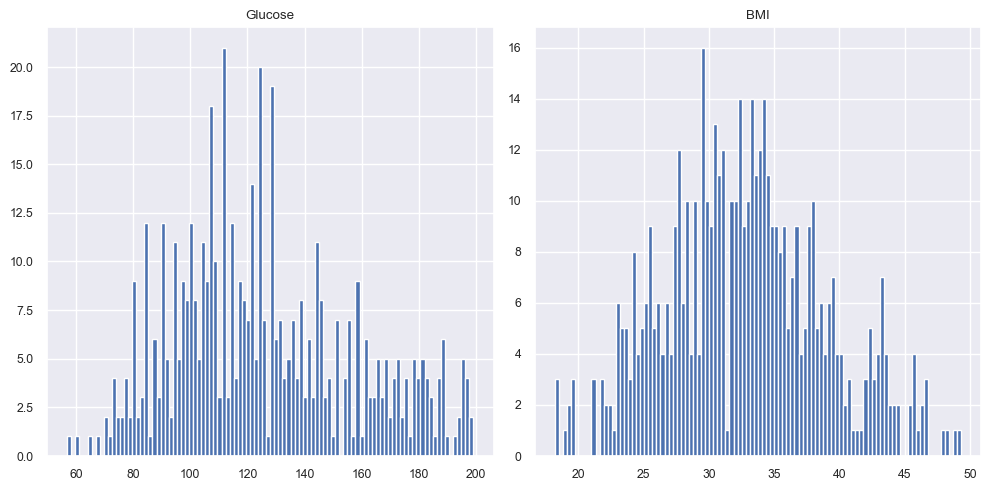

In [153]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]
    return df
columns_to_check = ['Glucose', 'BMI']
df = remove_outliers(df, columns_to_check)

df[columns_to_check].hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [74]:
# threshold = int(len(df) * 0.95)
# df_sorted = df.sort_values(by='Insulin')
# df = df_sorted.iloc[:threshold]
# df[columns_to_check].hist(bins=100, figsize=(10, 5))
# plt.tight_layout()
# plt.show()

In [154]:
(df == 0).sum()

Pregnancies                  59
Glucose                       0
BloodPressure                19
SkinThickness               158
Insulin                     255
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     259
dtype: int64

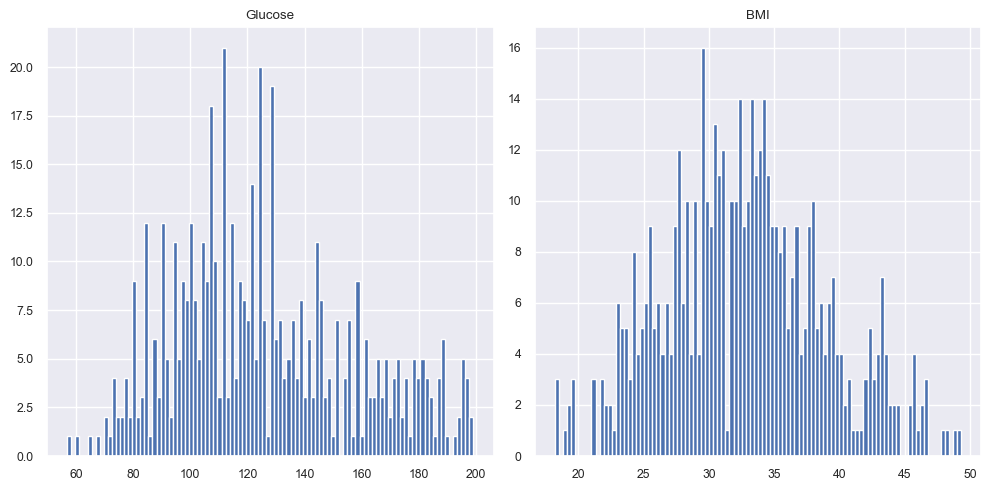

In [155]:
def replace_zeros_with_mean(df, cols):
    for col in cols:
        df[col].replace(0, df[col].mean(), inplace=True)
    return df

df = replace_zeros_with_mean(df, columns_to_check)
df[columns_to_check].hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

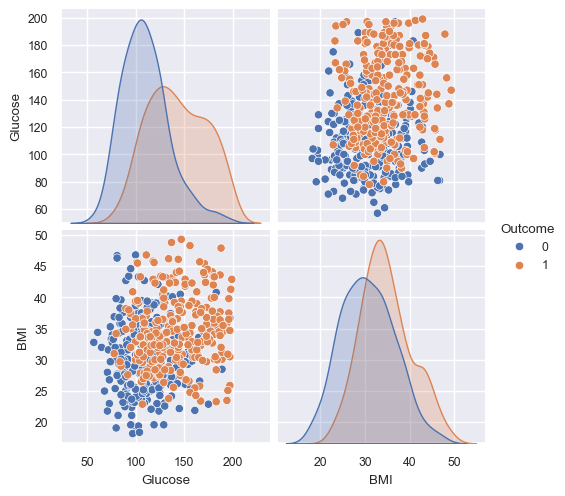

In [156]:
sns.pairplot(df,
             vars=columns_to_check,
            hue ='Outcome')
plt.show()

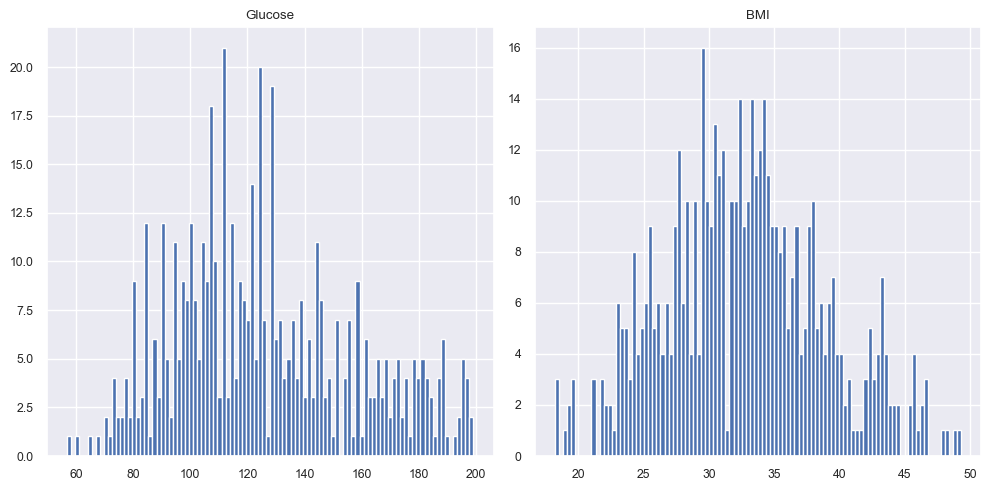

In [157]:
from sklearn.preprocessing import MinMaxScaler

X = df[columns_to_check]
X.hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [158]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = df['Outcome']  
y = label_encoder.fit_transform(y)
y

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### SVM 분류

In [161]:
clf_svm = SVC(random_state=0)
clf_svm.fit(X_train, y_train)

pred_svm = clf_svm.predict(X_test)

print("\n--- SVM Classifier ---")
print(accuracy_score(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))


--- SVM Classifier ---
0.7286821705426356
[[45 19]
 [16 49]]


### LR 분류

In [162]:
clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)

pred_lr = clf_lr.predict(X_test)

print ("\n--- Logistic Regression Classifier ---")
print (accuracy_score(y_test, pred_lr))
print (confusion_matrix(y_test, pred_lr))


--- Logistic Regression Classifier ---
0.751937984496124
[[47 17]
 [15 50]]


### KNN 분류

In [163]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, y_train)
pred_knn = clf_knn.predict(X_test)
print("\n--- KNN Classifier ---")
print(accuracy_score(y_test, pred_knn))
print(confusion_matrix(y_test, pred_knn))


--- KNN Classifier ---
0.6589147286821705
[[42 22]
 [22 43]]


### DT 분류

In [164]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)

pred_dt = clf_dt.predict(X_test)

print ("\n--- Decision Tree Classifier ---")
print (accuracy_score(y_test, pred_dt))
print (confusion_matrix(y_test, pred_dt))


--- Decision Tree Classifier ---
0.7054263565891473
[[43 21]
 [17 48]]


### RF 분류

In [165]:
print ("\n--- Radom Forest ---")
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test, pred))



--- Radom Forest ---
0.7131782945736435
[[43 21]
 [16 49]]


## 2. 동일한 데이터로 딥러닝 분류 수행하라. (dense layer 만 사용)

In [166]:
Y = pd.get_dummies(y).values

In [167]:
X = X.values
X

array([[ 97. ,  38.1],
       [ 78. ,  33.7],
       [111. ,  29.5],
       ...,
       [190. ,  35.5],
       [170. ,  44. ],
       [126. ,  30.1]])

In [168]:
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [169]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam

model = Sequential()

model.add(Dense(10,input_shape=(2,),activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(2,activation='sigmoid'))

model.compile(Adam(learning_rate=0.0001),'binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                30        
                                                                 
 dense_13 (Dense)            (None, 8)                 88        
                                                                 
 dense_14 (Dense)            (None, 6)                 54        
                                                                 
 dense_15 (Dense)            (None, 2)                 14        
                                                                 
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________


In [170]:
model_history=model.fit(x=X_train, y=y_train, epochs=40, batch_size=32,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

Epoch 1/40
13/13 [==============================] - 1s 15ms/step - loss: 0.6962 - accuracy: 0.4915 - val_loss: 0.6862 - val_accuracy: 0.5146
Epoch 2/40
13/13 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.4891 - val_loss: 0.6853 - val_accuracy: 0.5146
Epoch 3/40
13/13 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.4891 - val_loss: 0.6843 - val_accuracy: 0.5146
Epoch 4/40
13/13 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4891 - val_loss: 0.6834 - val_accuracy: 0.5146
Epoch 5/40
13/13 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4891 - val_loss: 0.6825 - val_accuracy: 0.5146
Epoch 6/40
13/13 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.4891 - val_loss: 0.6815 - val_accuracy: 0.5146
Epoch 7/40
13/13 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.4866 - val_loss: 0.6806 - val_accuracy: 0.5146
Epoch 8/40
13/13 [=

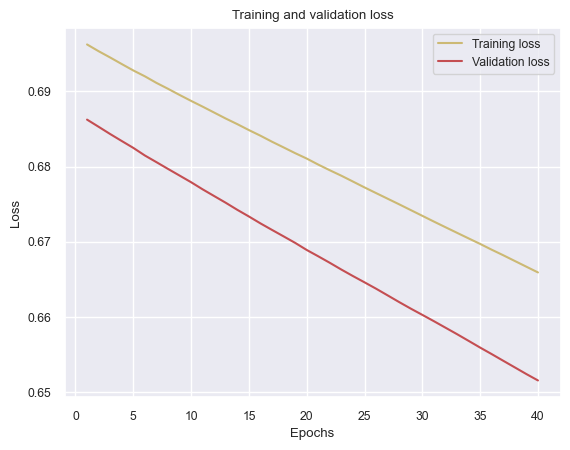

In [171]:
loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

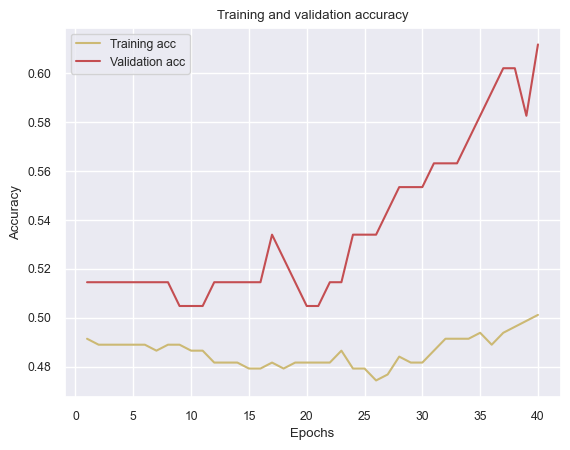

In [172]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [173]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        50
           1       0.59      0.81      0.68        53

    accuracy                           0.61       103
   macro avg       0.63      0.61      0.59       103
weighted avg       0.63      0.61      0.59       103

[[20 30]
 [10 43]]


## 3. 해당 데이터에서 Outcome을 삭제하고 BMI를 예측하는 회귀를 수행하라.

In [229]:
df = pd.read_csv("datas/diabetes.csv", index_col=0)
df


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,,,,,,,,
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...
10,101,76,48,180,32.9,0.171,63,0
2,122,70,27,0,36.8,0.340,27,0
5,121,72,23,112,26.2,0.245,30,0


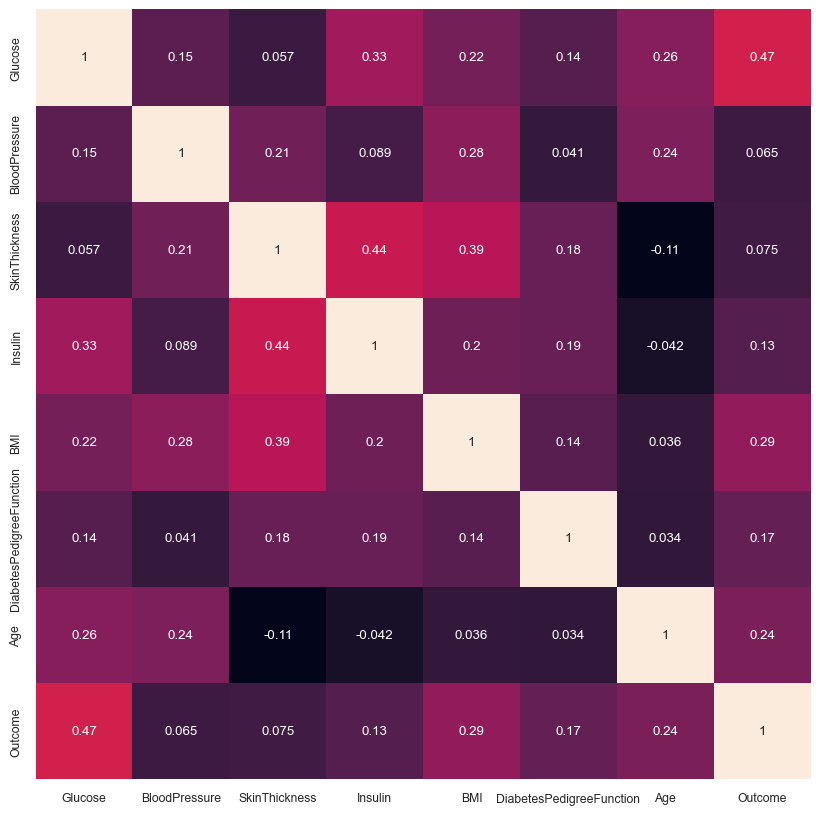

In [230]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
df_corr=df.corr()

plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar=False)
plt.show()

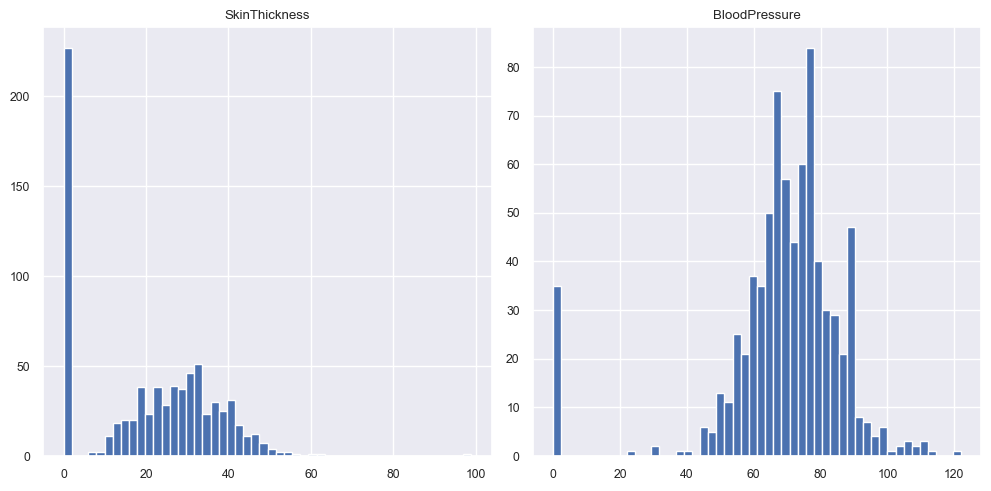

In [231]:
columns_to_check = ['SkinThickness', 'BloodPressure']

df[columns_to_check].hist(bins=50, figsize=(10, 5))
plt.tight_layout()
plt.show()

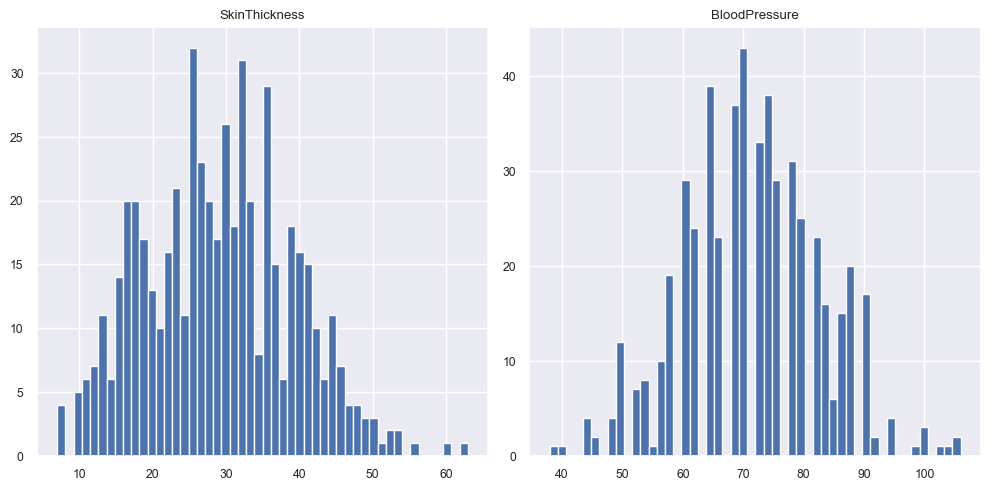

In [232]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))]
    return df

df = remove_outliers(df, columns_to_check)
df = df[df['SkinThickness'] != 0]

df[columns_to_check].hist(bins=50, figsize=(10, 5))
plt.tight_layout()
plt.show()

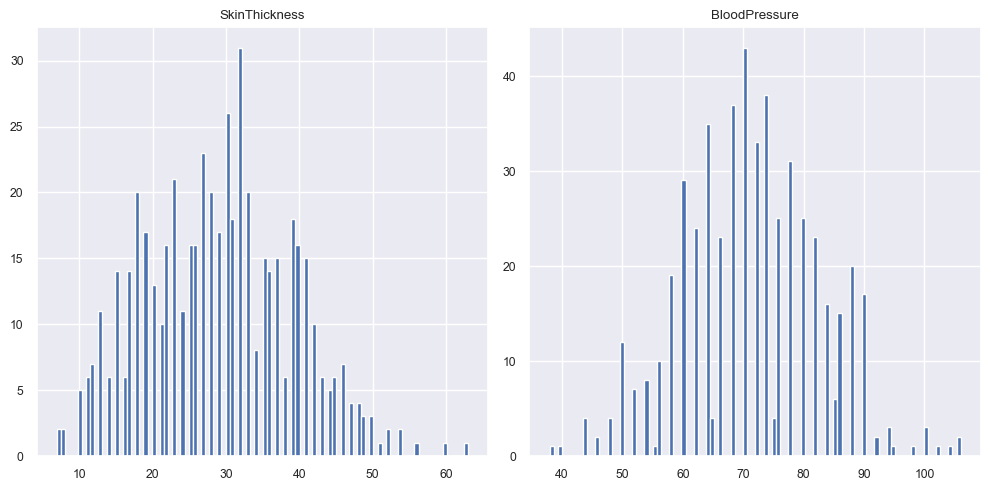

In [233]:
X = df[columns_to_check]
X.hist(bins=100, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [234]:
y = df['BMI'].values

In [236]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=12)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler_X.transform(X_test), columns=X.columns)

y_train = y_train.reshape(-1, 1) 
y_test = y_test.reshape(-1, 1)    

y_train = scaler_y.fit_transform(y_train) 
y_test = scaler_y.transform(y_test)

### Linear 회귀

In [237]:
model = LinearRegression()
model.fit(X_train, y_train)
ly_preds = model.predict(X_test)

    
print('평균제곱근오차', mean_squared_error(ly_preds, y_test))

평균제곱근오차 0.6181962009148244


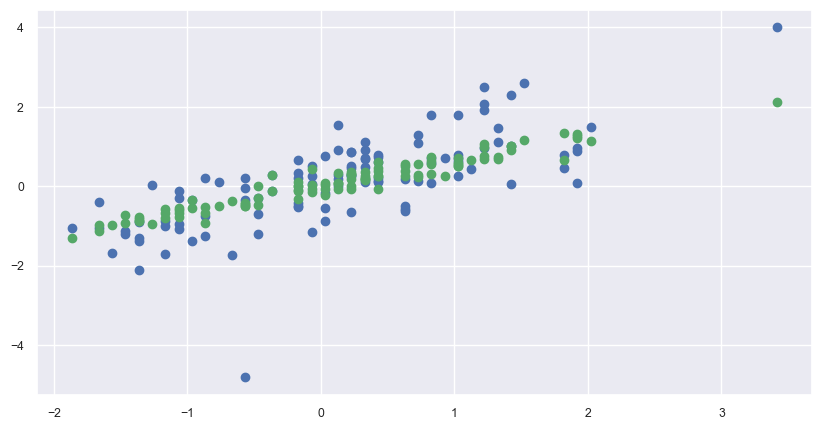

In [238]:
plt.figure(figsize=(10,5))
plt.scatter(X_test['SkinThickness'], y_test, label='y_test')
plt.scatter(X_test['SkinThickness'], ly_preds, c='g', label='ly_preds')
plt.show()   

### Decision Tree 회귀

In [239]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

dy_preds = model.predict(X_test)
print('평균제곱근오차', mean_squared_error(dy_preds, y_test))

평균제곱근오차 1.1187632540384478


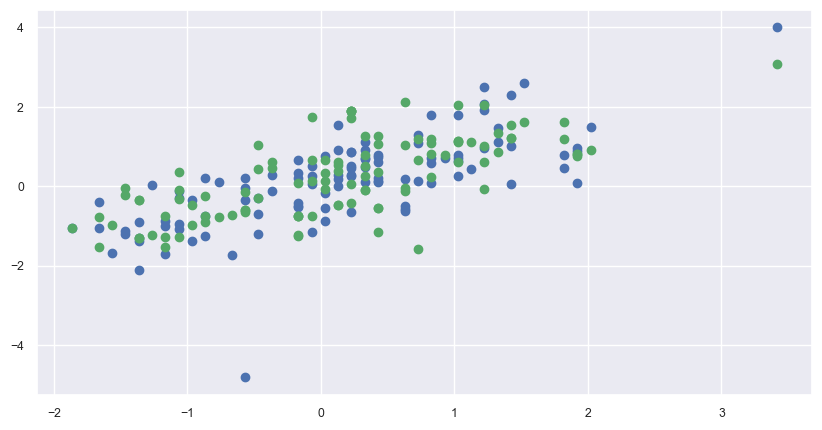

In [240]:
plt.figure(figsize=(10,5))
plt.scatter(X_test['SkinThickness'], y_test, label='y_test')
plt.scatter(X_test['SkinThickness'], dy_preds, c='g', label='dy_preds')
plt.show()   

### Random Forest 회귀

In [241]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
ry_preds = model.predict(X_test)
print('평균제곱근오차', mean_squared_error(ry_preds, y_test))

평균제곱근오차 0.7808508722966461


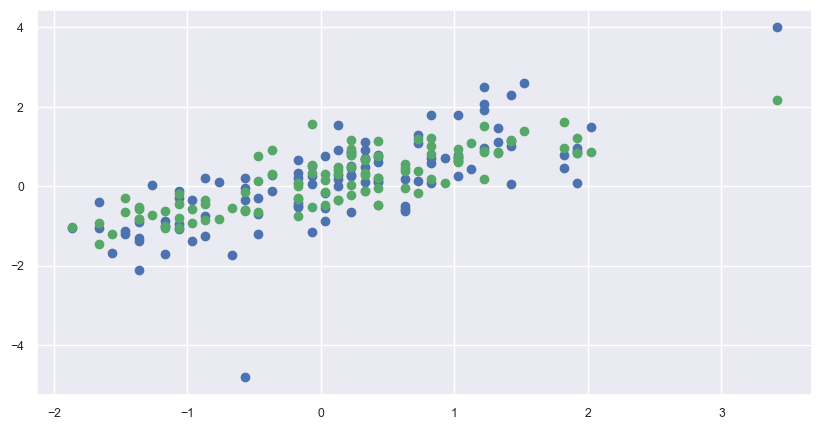

In [242]:
plt.figure(figsize=(10,5))
plt.scatter(X_test['SkinThickness'], y_test, label='y_test')
plt.scatter(X_test['SkinThickness'], ry_preds, c='g', label='ry_preds')
plt.show()  

### SVR 회귀

In [243]:
from sklearn.svm import SVR

model = SVR(kernel='linear')
model.fit(X_train, y_train)
ry_preds = model.predict(X_test)
print('평균제곱근오차', mean_squared_error(ry_preds, y_test))

평균제곱근오차 0.6357914526205234


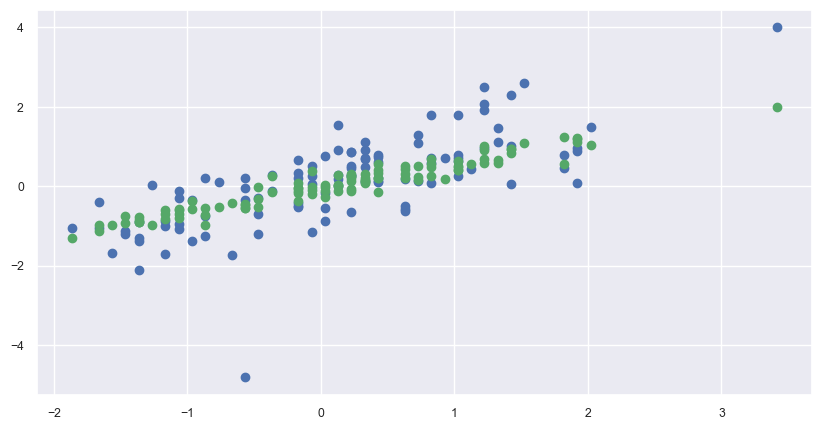

In [244]:
plt.figure(figsize=(10,5))
plt.scatter(X_test['SkinThickness'], y_test, label='y_test')
plt.scatter(X_test['SkinThickness'], ry_preds, c='g', label='ly_preds')
plt.show()  

## 4. 3번과 동일하지만 dense layer만 사용한 신경만으로 회귀를 수행하라.

In [260]:
y = df['BMI'].values
y

In [261]:
X = df[columns_to_check]
X = X.values
X

array([[35, 72],
       [29, 66],
       [23, 66],
       ...,
       [27, 70],
       [23, 72],
       [31, 70]])

In [262]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
                                                
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = y_train.reshape(-1, 1) 
y_test = y_test.reshape(-1, 1)    

y_train = scaler_y.fit_transform(y_train) 
y_test = scaler_y.transform(y_test)

print(X_train.shape)
print(y_train.shape)

(424, 2)
(424, 1)


In [263]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam

model = Sequential()

model.add(Dense(8,input_shape=(2,),activation='tanh'))
model.add(Dense(30,activation='tanh'))
model.add(Dense(30,activation='tanh'))
model.add(Dense(1))

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mse'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 8)                 24        
                                                                 
 dense_33 (Dense)            (None, 30)                270       
                                                                 
 dense_34 (Dense)            (None, 30)                930       
                                                                 
 dense_35 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,255
Trainable params: 1,255
Non-trainable params: 0
_________________________________________________________________


In [264]:
N_EPOCHS = 20

history=model.fit(x=X_train, y=y_train, epochs=N_EPOCHS, batch_size=32,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

Epoch 1/20
14/14 [==============================] - 1s 15ms/step - loss: 0.0233 - mse: 0.0233 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 3/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 6/20
14/14 [==============================] - 0s 3ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 7/20
14/14 [==============================] - 0s 3ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 8/20
14/14 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0

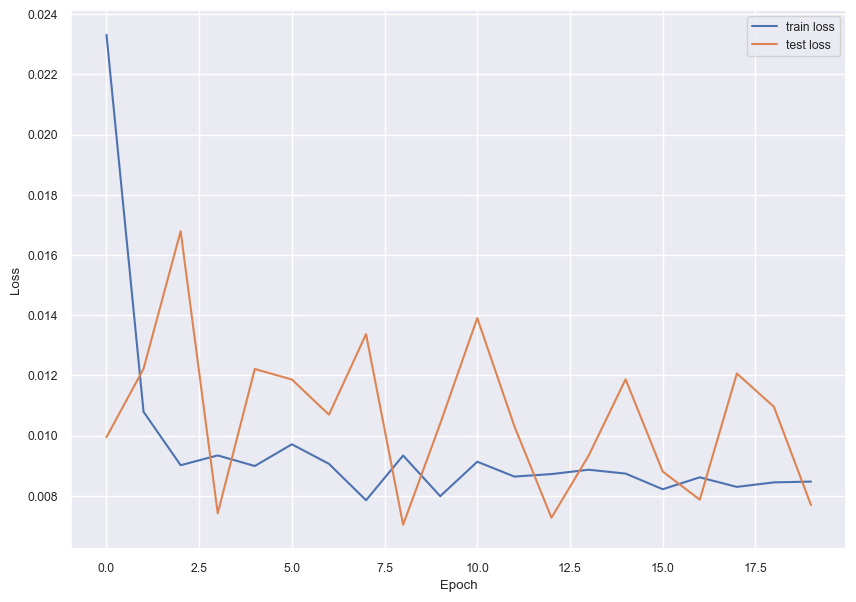

In [265]:
plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [266]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0077 - mse: 0.0077


[0.007688391488045454, 0.007688391953706741]